# **All Imports**

In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import platform
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phrases, Phraser 
import gensim.downloader as gensim_api
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, Input, LSTM, Dense 
from tensorflow.keras.models import Model 
from tensorflow.keras.utils import to_categorical

# **All Initializations**

In [25]:
OS = platform.system()   # Operating System
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# **All Globals**

In [16]:
pretrained_embeddings = False

# **All General Functions Definitions**

In [17]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

# **Data Download**

In [18]:
out = data_download("./News_Category_Dataset_v2.zip", "1O0JTnVgHcYppkR5hmj8sxkpgP4dI164C", OS)
category_dicts = []
with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
    for dic in json_file:
        category_dicts.append(json.loads(dic))

In [19]:
print(category_dicts[0:2])

[{'category': 'CRIME', 'headline': 'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV', 'authors': 'Melissa Jeltsen', 'link': 'https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89', 'short_description': 'She left her husband. He killed their children. Just another day in America.', 'date': '2018-05-26'}, {'category': 'ENTERTAINMENT', 'headline': "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song", 'authors': 'Andy McDonald', 'link': 'https://www.huffingtonpost.com/entry/will-smith-joins-diplo-and-nicky-jam-for-the-official-2018-world-cup-song_us_5b09726fe4b0fdb2aa541201', 'short_description': 'Of course it has a song.', 'date': '2018-05-26'}]


In [20]:
type(category_dicts[0])

dict

# **Data Preprocessing**

In [21]:
data = pd.DataFrame(category_dicts)
data = data[data["category"].isin(['ENTERTAINMENT','POLITICS','TECH'])][["category","headline"]]
data = data.rename(columns={"category":"labels", "headline":"text"})
data = data[['text', 'labels']]     # move cols
explore_data(data)


Head of Data: 
                                                 text         labels
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT
2    Hugh Grant Marries For The First Time At Age 57  ENTERTAINMENT
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  ENTERTAINMENT
4  Julianna Margulies Uses Donald Trump Poop Bags...  ENTERTAINMENT
5  Morgan Freeman 'Devastated' That Sexual Harass...  ENTERTAINMENT

Tail of Data: 
                                                      text labels
200844    Google+ Now Open for Teens With Some Safeguards   TECH
200845                                           Web Wars   TECH
200846  First White House Chief Technology Officer, An...   TECH
200847         Watch The Top 9 YouTube Videos Of The Week   TECH
200848  RIM CEO Thorsten Heins' 'Significant' Plans Fo...   TECH

Shape of Data:  (50879, 2)

Information about Data: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50879 entries, 1 to 200848
Data columns (total 2 columns):
 #  

#**Data Exploration**

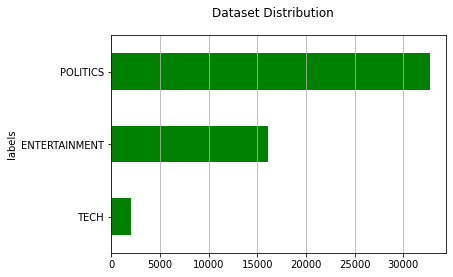

In [22]:
fig, ax = plt.subplots()
fig.suptitle("Dataset Distribution", fontsize=12)
data["labels"].reset_index().groupby("labels").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax, color = "green").grid(axis='x')
plt.show()

# **Data Cleaning Function Definition**

**6) back to string from list**

In [23]:
def clean_text(text, stemming=False, remove_stopwords = True, lemmatization=True, language = 'english', print_stopwords = False):
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip()) # (1)  
  lst_text = text.split()                                  # (2)
  if remove_stopwords: 
    lst_stopwords = nltk.corpus.stopwords.words(language)
    
    if lst_stopwords is not None:                          # (3)
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    if print_stopwords: 
      print(lst_text)

  if stemming:                                             # (4)
      ps = nltk.stem.porter.PorterStemmer()
      lst_text = [ps.stem(word) for word in lst_text]
              
  if lemmatization:                                        # (5) 
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      lst_text = [lem.lemmatize(word) for word in lst_text]
          
  text = " ".join(lst_text)                                # (6)
  
  return text

# **Data Cleaning**

In [26]:
data["text_clean"] = data["text"].apply(lambda x: clean_text(x, remove_stopwords = True, stemming=True, lemmatization=True)) 
explore_data(data)


Head of Data: 
                                                 text         labels  \
1  Will Smith Joins Diplo And Nicky Jam For The 2...  ENTERTAINMENT   
2    Hugh Grant Marries For The First Time At Age 57  ENTERTAINMENT   
3  Jim Carrey Blasts 'Castrato' Adam Schiff And D...  ENTERTAINMENT   
4  Julianna Margulies Uses Donald Trump Poop Bags...  ENTERTAINMENT   
5  Morgan Freeman 'Devastated' That Sexual Harass...  ENTERTAINMENT   

                                          text_clean  
1  smith join diplo nicki jam 2018 world cup offi...  
2                 hugh grant marri first time age 57  
3  jim carrey blast castrato adam schiff democrat...  
4  julianna marguli use donald trump poop bag pic...  
5  morgan freeman devast sexual harass claim coul...  

Tail of Data: 
                                                      text labels  \
200844    Google+ Now Open for Teens With Some Safeguards   TECH   
200845                                           Web Wars   TECH   
20084

# **Data Preparation**

Split dataset and get the target


In [ ]:
train_set, test_set = train_test_split(data, test_size=0.2)
train_y = train_set["labels"].values
test_y = test_set["labels"].values

In [ ]:
print(len(train_set))
print(len(test_set))
print(len(train_y))
print(len(test_y))

40703
10176
40703
10176


#**Embedding Layer with Gensim**

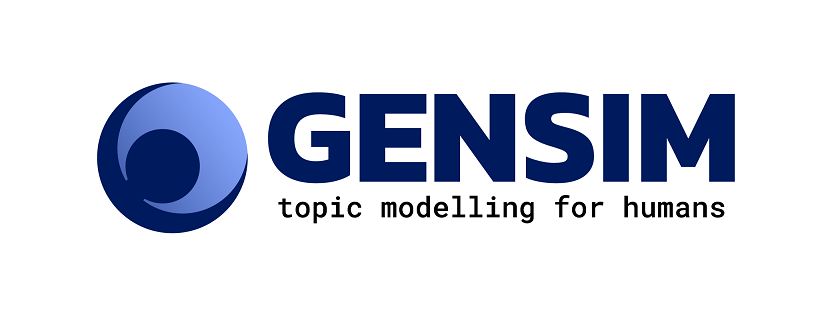

**Gensim** is a free open-source Python library for representing documents as semantic vectors, as efficiently (computer-wise) and painlessly (human-wise) as possible.

**Gensim** is designed to process raw, unstructured digital texts (“plain text”) using unsupervised machine learning algorithms.

The algorithms in Gensim, such as Word2Vec, FastText, Latent Semantic Indexing (LSI, LSA, LsiModel), Latent Dirichlet Allocation (LDA, LdaModel) etc, automatically discover the semantic structure of documents by examining statistical co-occurrence patterns within a corpus of training documents. These algorithms are unsupervised, which means no human input is necessary – you only need a corpus of plain text documents.

Once these statistical patterns are found, any plain text documents (sentence, phrase, word…) can be succinctly expressed in the new, semantic representation and queried for topical similarity against other documents (words, phrases…).

**gensim_api.load:** module is an API for downloading, getting information and loading datasets/models.

**gensim.models.phrases.Phrases:** Automatically detect common phrases – aka multi-word expressions, word n-gram collocations – from a stream of sentences.

**gensim.models.word2vec.Word2Vec:** implements the word2vec family of algorithms, using highly optimized C routines, data streaming and Pythonic interfaces. The word2vec algorithms include skip-gram and CBOW models, using either hierarchical softmax or negative sampling. The training is streamed, so ``sentences`` can be an iterable, reading input data from the disk or network on-the-fly, without loading your entire corpus into RAM.

**Critical Parameters for Word2Vec:**

**sentences (iterable of iterables, optional):** The sentences iterable can be simply a list of lists of tokens, but for larger corpora, consider an iterable that streams the sentences directly from disk/network. See BrownCorpus, Text8Corpus or LineSentence in word2vec module for such examples. See also the tutorial on data streaming in Python. If you don’t supply sentences, the model is left uninitialized – use if you plan to initialize it in some other way.

**corpus_file (str, optional):** Path to a corpus file in LineSentence format. You may use this argument instead of sentences to get performance boost. Only one of sentences or corpus_file arguments need to be passed (or none of them, in that case, the model is left uninitialized).

**size or vector_size (int, optional):** Dimensionality of the word vectors.

**window (int, optional):** Maximum distance between the current and predicted word within a sentence.

**min_count (int, optional):** Ignores all words with total frequency lower than this.

**iter or epochs (int, optional):** Number of iterations (epochs) over the corpus. (Formerly: iter)

**sg ({0, 1}, optional):** Training algorithm: 1 for skip-gram; otherwise CBOW.

In [ ]:
if pretrained_embeddings is True: 
  nlp = gensim_api.load("word2vec-google-news-300")
else: 
  corpus = train_set["text_clean"]

  # 1 - create list of lists of unigrams
  lst_corpus = []
  i = 0
  for string in corpus:
    lst_words = string.split()
    #print(lst_words)
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    #print(lst_grams)
    lst_corpus.append(lst_grams)
    '''
    i+=1
    if i > 4: 
      break
    '''
    
  # 2 - create a list of bigrams and trigrams
  bigrams_detector = Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)                     # Train a bigram model.
  bigrams_detector = Phraser(bigrams_detector)                                                                  # Export the trained model = use less RAM, faster processing
  trigrams_detector = Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)  # Train a trigram model.
  trigrams_detector = Phraser(trigrams_detector)

In [ ]:
print(type(lst_corpus))
print(type(bigrams_detector))
print(type(trigrams_detector))
print(len(lst_corpus))
print(lst_corpus)

<class 'list'>
<class 'gensim.models.phrases.Phraser'>
<class 'gensim.models.phrases.Phraser'>
40703
[['nra', 'doesnt', 'care', 'philando', 'castil', 'gun', 'right'], ['u', 'use', 'amazon', 'onlin', 'holiday', 'shop', 'year'], ['new', 'gilmor', 'girl', 'reviv', 'pic', 'matter', 'life', 'death'], ['republican', 'hustl', 'pas', 'tax', 'bill', 'one', 'realli', 'like'], ['here', 'cop', 'support', 'say', 'sandra', 'bland', 'arrest', 'video'], ['chri', 'pratt', 'might', 'abl', 'predict', 'futur'], ['plan', 'transform', 'u', 'immigr', 'detent', 'system'], ['california', 'farmer', 'agre', 'give', 'water'], ['support', 'presid', 'obama'], ['donald', 'trump', 'call', 'law', 'weve', 'alreadi', '20', 'year'], ['huffpost', 'hill', 'anyon', 'el', 'think', 'mike', 'penc', 'look', 'like', 'anderson', 'cooper', 'mix', 'john', 'boehner'], ['pharrel', 'ariana', 'grand', 'dave', 'matthew', 'band', 'announc', 'charlottesvil', 'benefit'], ['unsurprisingli', 'network', 'refus', 'air', 'donald', 'trump', 'fak

# **Word Embeddings Training by Gensim Word2Vec**

In [ ]:
embedding_model = Word2Vec(lst_corpus, size=300, window=8, min_count=1, sg=1, iter=30)
embedding_model.save("news_category_word2vec_embeddings.model")

#**Language Model Sanity Check**

In [ ]:
word = "data"
embedding_model[word].shape
print("Embeddings Coefficients for the word: ", word)
print("\n")
print(embedding_model[word])

Embeddings Coefficients for the word:  data


[-1.40390798e-01 -2.48121530e-01 -9.46978852e-02 -6.80624008e-01
  9.74513665e-02  2.27511555e-01 -1.78513229e-01 -2.65002429e-01
 -5.30808151e-01 -4.56632972e-01 -2.00035498e-01 -3.37873518e-01
 -7.07979262e-01  8.87041867e-01 -3.02678555e-01  1.03207462e-01
 -7.65844584e-02  1.81120664e-01 -1.48186624e-01  2.21739441e-01
 -3.24943960e-01 -3.97137344e-01  4.15241212e-01  1.86931133e-01
 -1.43450007e-01  5.85850954e-01 -9.37468465e-03  1.37983710e-01
  7.83833027e-01 -5.43242574e-01 -1.34419829e-01  1.48260683e-01
 -1.08140290e-01 -2.81050712e-01 -6.39238119e-01 -4.53609079e-01
  3.97948325e-02 -5.22796750e-01  3.35523427e-01  2.43133232e-02
  1.40839666e-01 -2.19559014e-01  1.09844334e-01  6.29110396e-01
 -1.54326737e-01 -1.08356617e-01  3.27012837e-01 -6.93693534e-02
 -4.16511327e-01 -1.59706071e-01  5.70819974e-01  4.36984450e-01
  2.53300935e-01  5.83791584e-02  1.37236118e-01  7.03988746e-02
  1.10708427e+00 -4.59013104e-01  2.93553770

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


#**Embedding Space Visualization Function**

Extracts the 20 more similar word embeddings and make use of pca to reduce dimensionality from 300 to 3, in order to plot vectors

In [ ]:
def embedding_space_visualization(root_word, model, plot_3d = True, plot_2d = False):
  fig = plt.figure(figsize=(20, 17), dpi=80)
  tot_words = [word] + [tupla[0] for tupla in model.most_similar(word, topn=40)]   
  X = model[tot_words]
  if plot_3d: 
    pca = TSNE(perplexity=40, n_components=3, init='pca')                           

    X = pca.fit_transform(X)
    pca_data = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    pca_data["input"] = 0
    pca_data["input"].iloc[0:1] = 1

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[pca_data["input"]==0]['x'], pca_data[pca_data["input"]==0]['y'], pca_data[pca_data["input"]==0]['z'], c="black")
    ax.scatter(pca_data[pca_data["input"]==1]['x'], pca_data[pca_data["input"]==1]['y'], pca_data[pca_data["input"]==1]['z'], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
    for label, row in pca_data[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)

# **Plot the Embedding Space**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithC

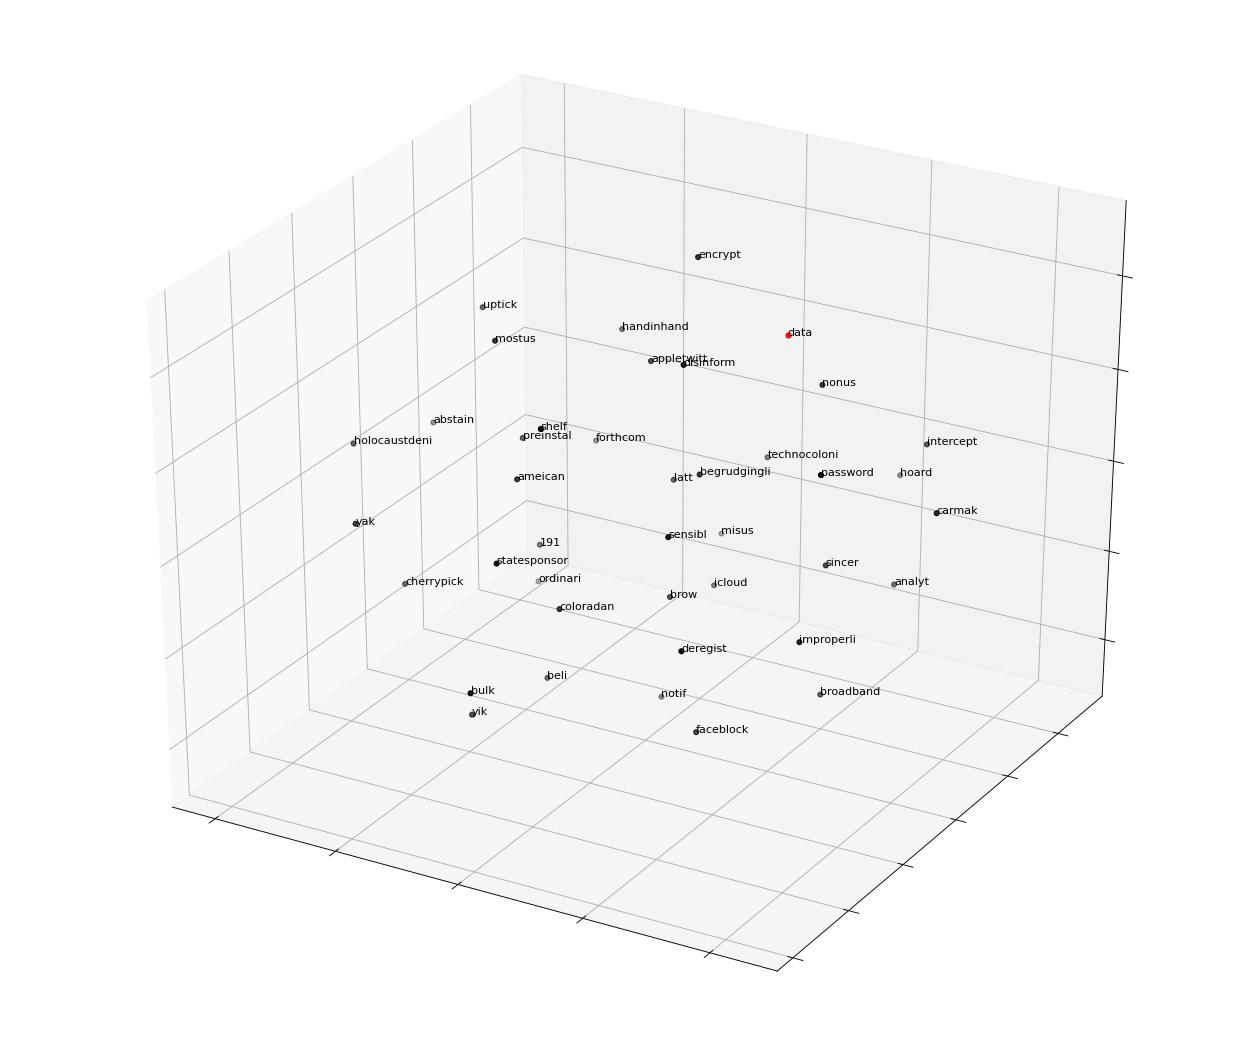

In [ ]:
embedding_space_visualization("data", embedding_model)

 # **Feature Engineering**

In [ ]:
tokenizer = Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # tokenize text
tokenizer.fit_on_texts(lst_corpus)
index_of_words = tokenizer.word_index
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)    ## create sequence
train_x = pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post") # pad sequences 

corpus = test_set["text_clean"]

lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

test_x = pad_sequences(lst_text2seq, maxlen=15, padding="post", truncating="post")

In [ ]:
print(train_x)
print(len(train_x))
print(test_x)
print(len(test_x))

[[ 644  121   59 ...    0    0    0]
 [   9   93  798 ...    0    0    0]
 [   4 1471  182 ...    0    0    0]
 ...
 [ 274   25   52 ...    0    0    0]
 [2129 5020  605 ...    0    0    0]
 [2675 3145  304 ...    0    0    0]]
40703
[[ 2014 13490   614 ...     0     0     0]
 [  680   172   361 ...     0     0     0]
 [ 5051  4666  3609 ...     0     0     0]
 ...
 [ 5482  1162   664 ...     0     0     0]
 [  920   408   708 ...     0     0     0]
 [    1   544  9877 ...     0     0     0]]
10176


# **Embeddings Matrix Building**

In [ ]:
embeddings_matrix = np.zeros((len(index_of_words)+1, 300))
for word, idx in index_of_words.items():
    try:
        embeddings_matrix[idx] =  embedding_model[word]
    except:
        pass
print(embeddings_matrix.shape)

(18551, 300)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


# **Labels Encoding**

In [ ]:
print("Original Labels: ")
print(train_y)
print(test_y)
lb_train = LabelEncoder()
lb_train.fit(train_y)
train_y = lb_train.transform(train_y)

lb_test = LabelEncoder()
lb_test.fit(test_y)
test_y = lb_test.transform(test_y)

# save label file so we can use in another script
np.save('./train_labels.npy', lb_train.classes_)
np.save('./test_labels.npy', lb_test.classes_)
print("Encoded Labels: ")
print(train_y)
print(test_y)


Original Labels: 
['POLITICS' 'TECH' 'ENTERTAINMENT' ... 'TECH' 'POLITICS' 'ENTERTAINMENT']
['POLITICS' 'POLITICS' 'ENTERTAINMENT' ... 'ENTERTAINMENT' 'POLITICS'
 'ENTERTAINMENT']
Encoded Labels: 
[1 2 0 ... 2 1 0]
[1 1 0 ... 0 1 0]


# **One-Hot Encoding of Outputs**

In [ ]:
print("Original Labels: ")
print(train_y)
print(test_y)
train_y = to_categorical(train_y, num_classes = 3)
test_y = to_categorical(train_y, num_classes = 3)
print("One-Hot Encoded Labels: ")
print(train_y)
print(test_y)
print(len(train_y))
print(len(test_y))


Original Labels: 
[1 2 0 ... 2 1 0]
[1 1 0 ... 0 1 0]
One-Hot Encoded Labels: 
[[0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]
[[[1. 0. 0.]
  [0. 1. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [0. 1. 0.]]

 [[0. 1. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]

 ...

 [[1. 0. 0.]
  [1. 0. 0.]
  [0. 1. 0.]]

 [[1. 0. 0.]
  [0. 1. 0.]
  [1. 0. 0.]]

 [[0. 1. 0.]
  [1. 0. 0.]
  [1. 0. 0.]]]
40703
40703


# **Deep Learning Model Definition**

We use a **Bidirectional** wrapper for RNNs and these two layers of Bidirectional LSTM are useful to model the order of words in a sequence in both directions. Return_sequences parameter for LSTM is used to return the last output, in the output sequence, or the full sequence, and it's necessary for the Bidirectional. 

**Bidirectional** long-short term memory(bi-lstm) is the process of making any neural network to have the sequence information in both directions backwards (future to past) or forward(past to future). In bidirectional, our input flows in two directions, making a bi-lstm different from the regular LSTM. With the regular LSTM, we can make input flow in one direction, either backwards or forward. However, in bi-directional, we can make the input flow in both directions to preserve the future and the past information. 

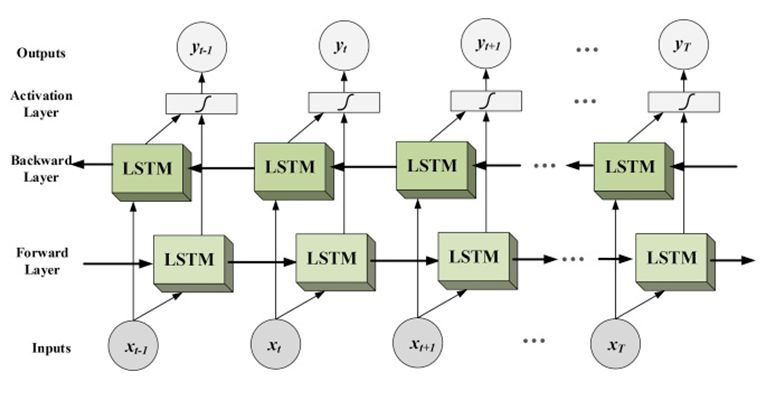

In [ ]:
input = Input(shape=(15,))
x = Embedding(input_dim=embeddings_matrix.shape[0], output_dim=embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=15, trainable=False)(input)
x = Bidirectional(LSTM(units=15, dropout=0.2, return_sequences=True))(x)
x = Bidirectional(LSTM(units=15, dropout=0.2))(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(input, predictions)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15)]              0         
                                                                 
 embedding (Embedding)       (None, 15, 300)           5565300   
                                                                 
 bidirectional (Bidirectiona  (None, 15, 30)           37920     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 30)               5520      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 64)                1984      
                                                                 
 dense_1 (Dense)             (None, 3)                 195   

# **Deep Learning Model Training**

In [ ]:
training = model.fit(train_x, train_y, batch_size=64, epochs=3, shuffle=True, verbose=1, validation_split=0.2)

Epoch 1/3
509/509 [==============================] - 29s 41ms/step - loss: 0.3010 - accuracy: 0.8865 - val_loss: 0.2082 - val_accuracy: 0.9267
Epoch 2/3
509/509 [==============================] - 19s 37ms/step - loss: 0.1983 - accuracy: 0.9297 - val_loss: 0.1942 - val_accuracy: 0.9331
Epoch 3/3
509/509 [==============================] - 19s 37ms/step - loss: 0.1816 - accuracy: 0.9358 - val_loss: 0.1881 - val_accuracy: 0.9356


# **Homeworks**

0) Create the Embedding Model on the entire set of news (200 thousand news) and train on the 3 classes subset

1) Recreate Word Embeddings on 20NewsGroup and IMDB Sentiment Dataset

2) Plot the Embeddings for both starting from a chosen root word

2) Retrain the Bidirectional LSTM on 20NewsGroup and IMDB Sentiment Dataset 

3) Add all the requried Callbacks and Save Best Model

4) Make pre and post processing exploratory analysis of true and predicted labels

5) Plot confusion matrices 

6) Add f1-score to the training process 

7) Test the model on test set with accuracy and test set 

8) Find the best Deep Learning model tuning the hyperparameters in order to find the best accuracies and f1-scores